- Train models on Combined cohort
- Test models on Trans test set (ignore the Combined test set created)
<br><br>
- 0 - cisgender
- 1 - transgender

# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report, accuracy_score, f1_score, matthews_corrcoef
from mlxtend.evaluate import paired_ttest_5x2cv
from pprint import pprint
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Read and Preview Data
- Entire dataset shape is (626121, 53)
- Transgender test set shape is (490, 53) - came from 'Trans Analysis - HYPERMED'
- Dataset showed decimal values which were probably produced by multiple imputation - these should be rounded

In [2]:
path = 'FINAL w surgspec dropped obgynsurgeries for transgender analysis 11-16.csv'
df = pd.read_csv(path)
df.drop(df.columns[[0, 1]], axis=1, inplace=True)
df.shape
df.head()

(626121, 53)

,INOUT,Age,ANESTHES,HEIGHT,WEIGHT,DIABETES,SMOKE,DYSPNEA,VENTILAT,HXCOPD,...,CNSCVA,CDARREST,CDMI,OTHBLEED,OTHDVT,OTHSYSEP,OTHSESHOCK,RETURNOR,DOptoDis,SEX
0,0.0,29.0,1.0,67.0,275.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0
1,1.0,54.0,1.0,63.0,140.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0.0,0.0,3.0,0
2,1.0,64.0,1.0,64.0,307.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,4.0,0
3,0.0,59.0,1.0,65.0,227.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0
4,1.0,62.0,1.0,69.0,201.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,3.0,0


In [3]:
trans_test = pd.read_csv('trans_test_set.csv')
trans_test.shape
trans_test.head()

(490, 53)

,INOUT,Age,ANESTHES,HEIGHT,WEIGHT,DIABETES,SMOKE,DYSPNEA,VENTILAT,HXCOPD,...,CDARREST,CDMI,OTHBLEED,OTHDVT,OTHSYSEP,OTHSESHOCK,RETURNOR,DOptoDis,SEX,HYPERMED
0,1.0,56.0,1.0,61.0,164.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,-0.0,0.0,3.0,1,0.0
1,0.0,50.0,1.0,68.0,190.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,1.0,1,0.0
2,1.0,32.0,1.0,63.0,171.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,1.0,1,0.0
3,1.0,53.0,1.0,64.0,212.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,3.0,1,0.0
4,0.0,38.0,1.0,66.0,224.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,1.0,1,0.0


# Preprocess Data
- Round decimal values that probably came from multiple imputation to the nearest integer
- Remove any rows with negative values after rounding
- Drop rows that contained negative values after the rounding
- All data from the Trans test set were from the Combined cohort. Remove all rows of the Trans test set from the Combined cohort to prevent data leakage. 
- The preprocessed dataframe 'df_dedup' contains the transgender patients that were in the Trans training set and all cisgender patients

In [4]:
df = df.round()
df[df < 0] = np.NaN
df.dropna(inplace=True)

merged = pd.merge(df, trans_test, how='outer', indicator=True)
df_dedup = merged.loc[merged._merge=='left_only']
df_dedup.drop(columns=['_merge'], inplace=True)
df_dedup.shape

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(625610, 53)

Note the small amount of transgender patients in the data. There will be a smaller amount that the models will be trained on after the train test split.

In [5]:
df_dedup['SEX'].value_counts(normalize=True)

0    0.997655
1    0.002345
Name: SEX, dtype: float64

# Preparation for Training Phase
- Helper functions for training and evaluating models
- Default 75-25 train test split
- y = HYPERMED is fairly imbalanced (~73% negative)

In [6]:
# returns the parts for ROC curve
def get_roc_curve_parts(clf):
    y_predict_proba = clf.predict_proba(trans_test.drop(columns='HYPERMED'))[::,1]
    fpr, tpr, thresholds = roc_curve(trans_test['HYPERMED'], y_predict_proba)
    roc_auc = roc_auc_score(trans_test['HYPERMED'], y_predict_proba)
    return y_predict_proba, fpr, tpr, roc_auc

In [7]:
# plots ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, label='ROC AUC='+'{:.2f}'.format(roc_auc))
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [8]:
# returns the 95 % confidence interval and parts of it, given the metric to be evaluated
def get_conf_int(metric, method, y_true, y_pred):
    n_bootstraps = 1000
    rng_seed = 42
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        if method == f1_score:
            score = method(y_true[indices], y_pred[indices], average='macro')
        else:
            score = method(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    confidence_interval = (np.round(confidence_lower,2), np.round(confidence_upper,2))
    
    return confidence_interval, confidence_lower, confidence_upper, bootstrapped_scores

In [9]:
# plots 95 % confidence interval for the given metric
def plot_conf_int(metric, confidence_lower, confidence_upper, bootstrapped_scores):
    plt.hist(bootstrapped_scores, bins=50)
    plt.title('Histogram of the Bootstrapped Metric Value')
    plt.show()
    print('Original Metric Value - {:0.2f}'.format(metric))
    print('95% Confidence Interval for the Metric Value - [{:0.2f}, {:0.2f}]'.format(confidence_lower, confidence_upper))

In [10]:
# plots precision-recall curve
def plot_pr_curve(y_predict_proba):
    precision, recall, thresholds = precision_recall_curve(trans_test['HYPERMED'], y_predict_proba)
    pr_auc = auc(recall, precision)
    pr_no_skill = len(trans_test['HYPERMED'][trans_test['HYPERMED']==1]) / len(trans_test['HYPERMED'])
    plt.plot([0, 1], [pr_no_skill, pr_no_skill], linestyle='--')
    plt.plot(recall, precision, label='PR AUC='+'{:.2f}'.format(pr_auc))
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=1)
    plt.show()
    return precision, recall, pr_auc

In [11]:
# returns and prints classification report
def show_classification_report(y_predict):
    print(confusion_matrix(trans_test['HYPERMED'], y_predict))
    report = classification_report(trans_test['HYPERMED'], y_predict, output_dict=True)
    pprint(report)
    return report

In [12]:
y = df_dedup['HYPERMED']
X = df_dedup.drop(columns=[y.name])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [13]:
y_true = np.array(trans_test['HYPERMED'])

In [14]:
y.value_counts(normalize=True)*100

0.0    72.75651
1.0    27.24349
Name: HYPERMED, dtype: float64

# Logistic Regression
- Includes a 95% confidence interval for each metric except for PR AUC
- Hyperparameters
    - max_iter - set number of iterations for model to try to converge for minimum error (difference between actual value and predicted value) 
    - For more hyperparameters and broad descriptions, refer to https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [15]:
logreg = LogisticRegression(max_iter=1000000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(trans_test.drop(columns='HYPERMED'))
acc_logreg = accuracy_score(y_true, y_pred_logreg)
print('Accuracy -', round(acc_logreg,2))

LogisticRegression(max_iter=1000000)

Accuracy - 0.83


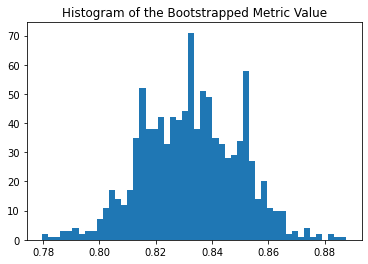

Original Metric Value - 0.83
95% Confidence Interval for the Metric Value - [0.80, 0.87]


In [16]:
ci_acc_logreg, lower_acc_logreg, upper_acc_logreg, bootstrap_acc_logreg = get_conf_int(acc_logreg, accuracy_score, y_true, y_pred_logreg)
plot_conf_int(acc_logreg, lower_acc_logreg, upper_acc_logreg, bootstrap_acc_logreg)

### ROC Curve

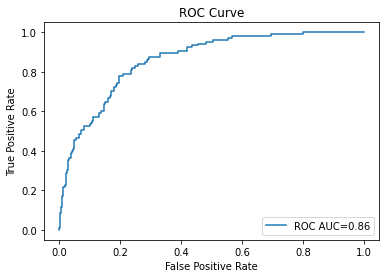

In [17]:
y_pred_proba_logreg, fpr_logreg, tpr_logreg, roc_logreg = get_roc_curve_parts(logreg)
plot_roc_curve(fpr_logreg, tpr_logreg, roc_logreg)

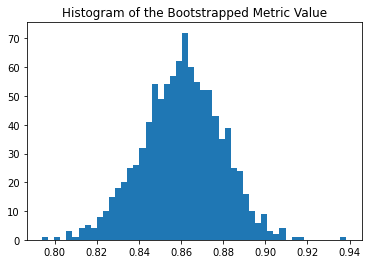

Original Metric Value - 0.86
95% Confidence Interval for the Metric Value - [0.82, 0.90]


In [18]:
ci_roc_logreg, lower_roc_logreg, upper_roc_logreg, bootstrap_roc_logreg = get_conf_int(roc_logreg, roc_auc_score, y_true, y_pred_proba_logreg)
plot_conf_int(roc_logreg, lower_roc_logreg, upper_roc_logreg, bootstrap_roc_logreg)

### PR Curve

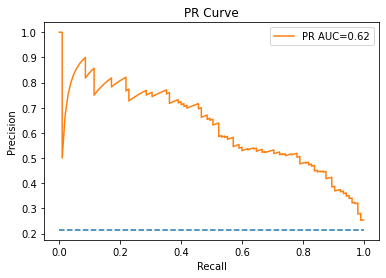

In [19]:
precision_logreg, recall_logreg, pr_logreg = plot_pr_curve(y_pred_proba_logreg)

### Confusion Matrix and Classification Report

In [20]:
report_logreg = show_classification_report(y_pred_logreg)

[[354  31]
 [ 51  54]]
{'0.0': {'f1-score': 0.8962025316455696,
         'precision': 0.8740740740740741,
         'recall': 0.9194805194805195,
         'support': 385},
 '1.0': {'f1-score': 0.5684210526315788,
         'precision': 0.6352941176470588,
         'recall': 0.5142857142857142,
         'support': 105},
 'accuracy': 0.8326530612244898,
 'macro avg': {'f1-score': 0.7323117921385742,
               'precision': 0.7546840958605665,
               'recall': 0.7168831168831169,
               'support': 490},
 'weighted avg': {'f1-score': 0.8259636432854287,
                  'precision': 0.8229069405539994,
                  'recall': 0.8326530612244898,
                  'support': 490}}


### F1 Score (Macro/Unweighted)

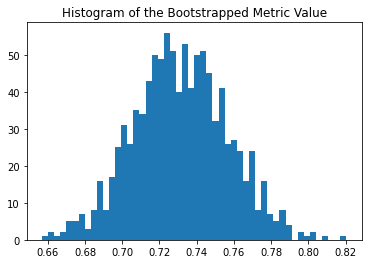

Original Metric Value - 0.73
95% Confidence Interval for the Metric Value - [0.68, 0.78]


In [21]:
f1_logreg = report_logreg['macro avg']['f1-score']
ci_f1_logreg, lower_f1_logreg, upper_f1_logreg, bootstrap_f1_logreg = get_conf_int(f1_logreg, f1_score, y_true, y_pred_logreg)
plot_conf_int(f1_logreg, lower_f1_logreg, upper_f1_logreg, bootstrap_f1_logreg)

### Matthews Correlation Coefficient

In [22]:
mcc_logreg = matthews_corrcoef(trans_test['HYPERMED'], y_pred_logreg)
print('MCC -', round(mcc_logreg,2))

MCC - 0.47


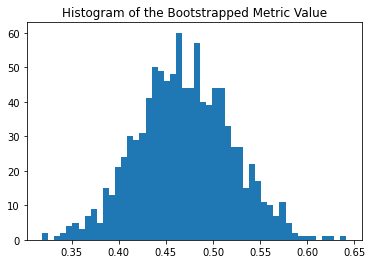

Original Metric Value - 0.47
95% Confidence Interval for the Metric Value - [0.37, 0.57]


In [23]:
ci_mcc_logreg, lower_mcc_logreg, upper_mcc_logreg, bootstrap_mcc_logreg = get_conf_int(mcc_logreg, matthews_corrcoef, y_true, y_pred_logreg)
plot_conf_int(mcc_logreg, lower_mcc_logreg, upper_mcc_logreg, bootstrap_mcc_logreg)

# Random Forest
- Includes a 95% confidence interval for each metric except for PR AUC

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(trans_test.drop(columns='HYPERMED'))
acc_rf = accuracy_score(y_true, y_pred_rf)
print('Accuracy -', round(acc_rf,2))

RandomForestClassifier()

Accuracy - 0.85


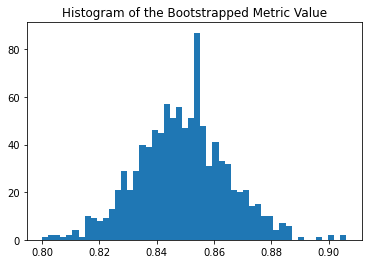

Original Metric Value - 0.85
95% Confidence Interval for the Metric Value - [0.82, 0.88]


In [25]:
ci_acc_rf, lower_acc_rf, upper_acc_rf, bootstrap_acc_rf = get_conf_int(acc_rf, accuracy_score, y_true, y_pred_rf)
plot_conf_int(acc_rf, lower_acc_rf, upper_acc_rf, bootstrap_acc_rf)

### ROC Curve

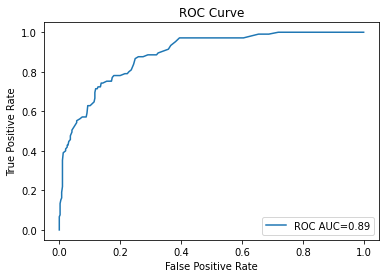

In [26]:
y_pred_proba_rf, fpr_rf, tpr_rf, roc_rf = get_roc_curve_parts(rf)
plot_roc_curve(fpr_rf, tpr_rf, roc_rf)

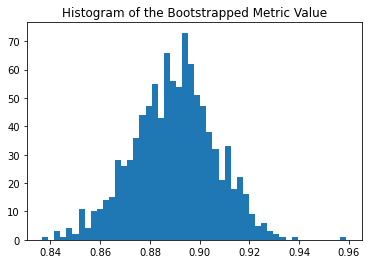

Original Metric Value - 0.89
95% Confidence Interval for the Metric Value - [0.85, 0.92]


In [27]:
ci_roc_rf, lower_roc_rf, upper_roc_rf, bootstrap_roc_rf = get_conf_int(roc_rf, roc_auc_score, y_true, y_pred_proba_rf)
plot_conf_int(roc_rf, lower_roc_rf, upper_roc_rf, bootstrap_roc_rf)

### PR Curve

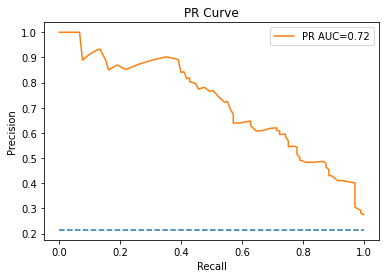

In [28]:
precision_rf, recall_rf, pr_rf = plot_pr_curve(y_pred_proba_rf)

### Confusion Matrix and Classification Report

In [29]:
report_rf = show_classification_report(y_pred_rf)

[[356  29]
 [ 45  60]]
{'0.0': {'f1-score': 0.905852417302799,
         'precision': 0.8877805486284289,
         'recall': 0.9246753246753247,
         'support': 385},
 '1.0': {'f1-score': 0.6185567010309277,
         'precision': 0.6741573033707865,
         'recall': 0.5714285714285714,
         'support': 105},
 'accuracy': 0.8489795918367347,
 'macro avg': {'f1-score': 0.7622045591668634,
               'precision': 0.7809689259996078,
               'recall': 0.7480519480519481,
               'support': 490},
 'weighted avg': {'f1-score': 0.8442890495302552,
                  'precision': 0.8420041389303627,
                  'recall': 0.8489795918367347,
                  'support': 490}}


### F1 Score (Macro/Unweighted)

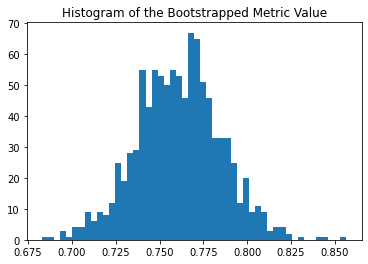

Original Metric Value - 0.76
95% Confidence Interval for the Metric Value - [0.71, 0.81]


In [30]:
f1_rf = report_rf['macro avg']['f1-score']
ci_f1_rf, lower_f1_rf, upper_f1_rf, bootstrap_f1_rf = get_conf_int(f1_rf, f1_score, y_true, y_pred_rf)
plot_conf_int(f1_rf, lower_f1_rf, upper_f1_rf, bootstrap_f1_rf)

### Matthews Correlation Coefficient

In [31]:
mcc_rf = matthews_corrcoef(trans_test['HYPERMED'], y_pred_rf)
print('MCC -', round(mcc_rf,2))

MCC - 0.53


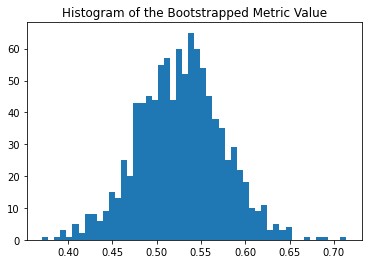

Original Metric Value - 0.53
95% Confidence Interval for the Metric Value - [0.43, 0.62]


In [32]:
ci_mcc_rf, lower_mcc_rf, upper_mcc_rf, bootstrap_mcc_rf = get_conf_int(mcc_rf, matthews_corrcoef, y_true, y_pred_rf)
plot_conf_int(mcc_rf, lower_mcc_rf, upper_mcc_rf, bootstrap_mcc_rf)

# XGBoost
- Includes a 95% confidence interval for each metric except for PR AUC
- Hyperparameters
    - max_iter - set number of iterations for model to try to converge for minimum error (difference between actual value and predicted value) 
    - For more hyperparameters and broard descriptions, refer to https://xgboost.readthedocs.io/en/latest/parameter.html

In [33]:
xgb = XGBClassifier(max_iter=1000000)
xgb.fit(X_train, y_train)
y_pred_xgb =  xgb.predict(trans_test.drop(columns='HYPERMED'))
acc_xgb = accuracy_score(y_true, y_pred_xgb)
print('Accuracy -', round(acc_xgb,2))

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, max_iter=1000000,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Accuracy - 0.85


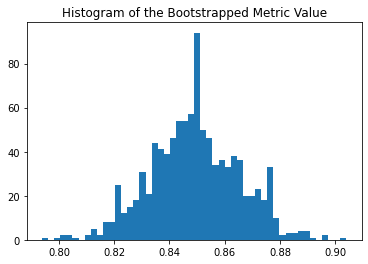

Original Metric Value - 0.85
95% Confidence Interval for the Metric Value - [0.82, 0.88]


In [34]:
ci_acc_xgb, lower_acc_xgb, upper_acc_xgb, bootstrap_acc_xgb = get_conf_int(acc_xgb, accuracy_score, y_true, y_pred_xgb)
plot_conf_int(acc_xgb, lower_acc_xgb, upper_acc_xgb, bootstrap_acc_xgb)

### ROC Curve

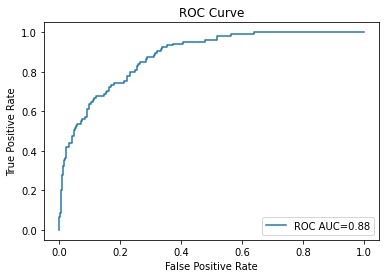

In [35]:
y_pred_proba_xgb, fpr_xgb, tpr_xgb, roc_xgb = get_roc_curve_parts(xgb)
plot_roc_curve(fpr_xgb, tpr_xgb, roc_xgb)

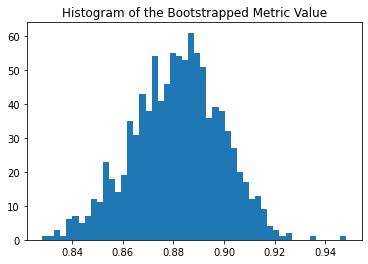

Original Metric Value - 0.88
95% Confidence Interval for the Metric Value - [0.85, 0.91]


In [36]:
ci_roc_xgb, lower_roc_xgb, upper_roc_xgb, bootstrap_roc_xgb = get_conf_int(roc_xgb, roc_auc_score, y_true, y_pred_proba_xgb)
plot_conf_int(roc_xgb, lower_roc_xgb, upper_roc_xgb, bootstrap_roc_xgb)

### PR Curve

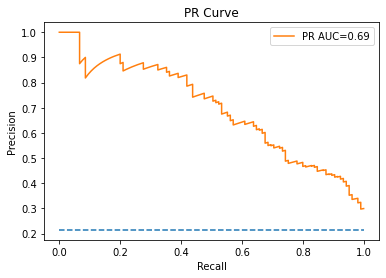

In [37]:
precision_xgb, recall_xgb, pr_xgb = plot_pr_curve(y_pred_proba_xgb)

### Confusion Matrix and Classification Report

In [38]:
report_xgb = show_classification_report(y_pred_xgb)

[[358  27]
 [ 47  58]]
{'0.0': {'f1-score': 0.9063291139240506,
         'precision': 0.8839506172839506,
         'recall': 0.9298701298701298,
         'support': 385},
 '1.0': {'f1-score': 0.6105263157894737,
         'precision': 0.6823529411764706,
         'recall': 0.5523809523809524,
         'support': 105},
 'accuracy': 0.8489795918367347,
 'macro avg': {'f1-score': 0.7584277148567622,
               'precision': 0.7831517792302106,
               'recall': 0.7411255411255411,
               'support': 490},
 'weighted avg': {'f1-score': 0.8429428000380699,
                  'precision': 0.8407511152609192,
                  'recall': 0.8489795918367347,
                  'support': 490}}


### F1 Score (Macro/Unweighted)

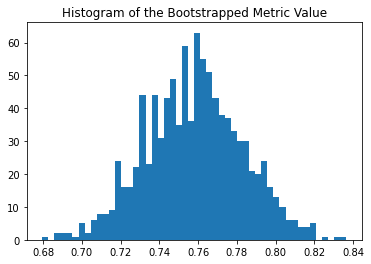

Original Metric Value - 0.76
95% Confidence Interval for the Metric Value - [0.71, 0.81]


In [39]:
f1_xgb = report_xgb['macro avg']['f1-score']
ci_f1_xgb, lower_f1_xgb, upper_f1_xgb, bootstrap_f1_xgb = get_conf_int(f1_xgb, f1_score, y_true, y_pred_xgb)
plot_conf_int(f1_xgb, lower_f1_xgb, upper_f1_xgb, bootstrap_f1_xgb)

### Matthews Correlation Coefficient

In [40]:
mcc_xgb = matthews_corrcoef(trans_test['HYPERMED'], y_pred_xgb)
print('MCC -', round(mcc_xgb,2))

MCC - 0.52


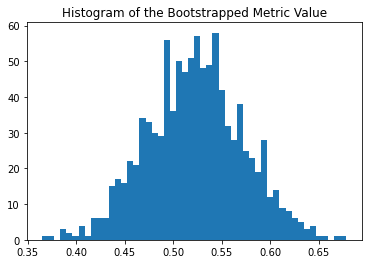

Original Metric Value - 0.52
95% Confidence Interval for the Metric Value - [0.43, 0.62]


In [41]:
ci_mcc_xgb, lower_mcc_xgb, upper_mcc_xgb, bootstrap_mcc_xgb = get_conf_int(mcc_xgb, matthews_corrcoef, y_true, y_pred_xgb)
plot_conf_int(mcc_xgb, lower_mcc_xgb, upper_mcc_xgb, bootstrap_mcc_xgb)

# Comparison Summary
### Accuracy

In [42]:
accuracy_df = pd.DataFrame()
accuracy_df['Model'] = ['Logistic Regression',
                        'Random Forest',
                        'XGBoost']
accuracy_df['Accuracy'] = [round(score,2) for score in [acc_logreg, acc_rf, acc_xgb]]

total_acc = accuracy_df
total_acc['Accuracy'] = total_acc['Accuracy'].astype(str)
ci_acc_list = [ci_acc_logreg, 
               ci_acc_rf, 
               ci_acc_xgb]
for acc, ci, idx in zip(total_acc['Accuracy'], ci_acc_list, range(len(total_acc))):
    total_acc['Accuracy'][idx] = ' '.join([str(acc), str(tuple([round(bound,2) for bound in ci]))])
total_acc

,Model,Accuracy
0,Logistic Regression,"0.83 (0.8, 0.87)"
1,Random Forest,"0.85 (0.82, 0.88)"
2,XGBoost,"0.85 (0.82, 0.88)"


### ROC AUC

In [43]:
roc_df = pd.DataFrame()
roc_df['Model'] = ['Logistic Regression',
                   'Random Forest',
                   'XGBoost']
roc_df['ROC AUC'] = [round(roc,2) for roc in [roc_logreg, roc_rf, roc_xgb]]

total_roc = roc_df
total_roc['ROC AUC'] = total_roc['ROC AUC'].astype(str)
ci_roc_list = [ci_roc_logreg,
               ci_roc_rf,
               ci_roc_xgb]
for acc, ci, idx in zip(total_roc['ROC AUC'], ci_roc_list, range(len(total_roc))):
    total_roc['ROC AUC'][idx] = ' '.join([str(acc), str(tuple([round(bound,2) for bound in ci]))])
total_roc

,Model,ROC AUC
0,Logistic Regression,"0.86 (0.82, 0.9)"
1,Random Forest,"0.89 (0.85, 0.92)"
2,XGBoost,"0.88 (0.85, 0.91)"


### F1 Score (Macro/Unweighted)

In [44]:
f1_df = pd.DataFrame()
f1_df['Model'] = ['Logistic Regression',
                  'Random Forest',
                  'XGBoost']
f1_df['F1'] = [round(f1,2) for f1 in [f1_logreg, f1_rf, f1_xgb]]

total_f1 = f1_df
total_f1['F1'] = total_f1['F1'].astype(str)
ci_f1_list = [ci_f1_logreg,
              ci_f1_rf,
              ci_f1_xgb]
for acc, ci, idx in zip(total_f1['F1'], ci_f1_list, range(len(total_f1))):
    total_f1['F1'][idx] = ' '.join([str(acc), str(tuple([round(bound,2) for bound in ci]))]) 
total_f1

,Model,F1
0,Logistic Regression,"0.73 (0.68, 0.78)"
1,Random Forest,"0.76 (0.71, 0.81)"
2,XGBoost,"0.76 (0.71, 0.81)"


### Matthews Correlation Coefficient

In [45]:
mcc_df = pd.DataFrame()
mcc_df['Model'] = ['Logistic Regression',
                   'Random Forest',
                   'XGBoost']
mcc_df['MCC'] = [round(mcc,2) for mcc in [mcc_logreg, mcc_rf, mcc_xgb]]

total_mcc = mcc_df
total_mcc['MCC'] = total_mcc['MCC'].astype(str)
ci_mcc_list = [ci_mcc_logreg,
               ci_mcc_rf,
               ci_mcc_xgb]
for acc, ci, idx in zip(total_mcc['MCC'], ci_mcc_list, range(len(total_mcc))):
    total_mcc['MCC'][idx] = ' '.join([str(acc), str(tuple([round(bound,2) for bound in ci]))])
total_mcc

,Model,MCC
0,Logistic Regression,"0.47 (0.37, 0.57)"
1,Random Forest,"0.53 (0.43, 0.62)"
2,XGBoost,"0.52 (0.43, 0.62)"


### Consolidated Results

In [46]:
total = total_acc.merge(total_roc, on='Model').merge(total_f1, on='Model').merge(total_mcc, on='Model')
total

,Model,Accuracy,ROC AUC,F1,MCC
0,Logistic Regression,"0.83 (0.8, 0.87)","0.86 (0.82, 0.9)","0.73 (0.68, 0.78)","0.47 (0.37, 0.57)"
1,Random Forest,"0.85 (0.82, 0.88)","0.89 (0.85, 0.92)","0.76 (0.71, 0.81)","0.53 (0.43, 0.62)"
2,XGBoost,"0.85 (0.82, 0.88)","0.88 (0.85, 0.91)","0.76 (0.71, 0.81)","0.52 (0.43, 0.62)"


### ROC Curve Comparison for Logistic Regression Models from All 3 Cohorts

In [47]:
with open('trans-logreg-roc-auc.json') as file:
    trans_json = json.load(file)
    
with open('trans-cis-logreg-roc-auc.json') as file:
    trans_cis_json = json.load(file)

# pprint(trans_json)
# pprint(trans_cis_json)

Text(0.5, 1.0, 'ROC Curve Comparison for Logistic Regression Models')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

(0.2, 1.03)

(0.0, 1.0)

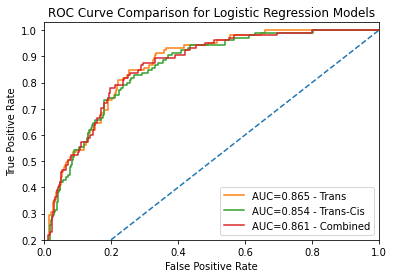

In [48]:
trans_fpr = trans_json['fpr']
trans_tpr = trans_json['tpr']
trans_roc = trans_json['roc']

trans_cis_fpr = trans_cis_json['fpr']
trans_cis_tpr = trans_cis_json['tpr']
trans_cis_roc = trans_cis_json['roc']

all_0 = [0 for entry in range(len(trans_test['HYPERMED']))]
auc_0 = roc_auc_score(trans_test['HYPERMED'], all_0)
fpr_0, tpr_0, thresholds_0 = roc_curve(trans_test['HYPERMED'], all_0)
plt.plot(fpr_0, tpr_0, linestyle='--')
plt.plot(trans_fpr, trans_tpr, label="AUC="+str(round(trans_roc,3))+' - Trans')
plt.plot(trans_cis_fpr, trans_cis_tpr, label="AUC="+str(round(trans_cis_roc,3))+' - Trans-Cis')
plt.plot(fpr_logreg, tpr_logreg, label="AUC="+str(round(roc_logreg,3))+' - Combined')
plt.title('ROC Curve Comparison for Logistic Regression Models')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim([0.2,1.03])   # adjust y-axis range, comment out and rerun for default zoomed
plt.xlim([0,1])        # adjust x-axis range, comment out and rerun for default zoom
plt.legend(loc=4)
plt.show()

# Export Models

In [49]:
pickle.dump(logreg, open('combined-logreg.sav','wb'))
pickle.dump(rf, open('combined-rf.sav','wb'))
pickle.dump(xgb, open('combined-xgb.sav','wb'))

# Statistical Hypothesis Testing to Evaluate Classifier Performance
Uses 5x2cv paired t-test

In [50]:
logreg_trans = pickle.load(open('trans-logreg.sav','rb'))
logreg_trans_cis = pickle.load(open('trans-cis-logreg.sav','rb'))
rf_trans = pickle.load(open('trans-rf.sav','rb'))
rf_trans_cis = pickle.load(open('trans-cis-rf.sav','rb'))
xgb_trans = pickle.load(open('trans-xgb.sav','rb'))
xgb_trans_cis = pickle.load(open('trans-cis-xgb.sav','rb'))

In [51]:
y_ = df['HYPERMED']
X_ = df.drop(columns=[y_.name])

### Logistic Regression

In [52]:
t1, p1 = paired_ttest_5x2cv(logreg_trans, logreg_trans_cis, X_, y_, 'accuracy')
print('Trans - Trans-Cis (Logistic Regression)')
print(f'P-value = {p1:.3f}')
print(f't-statistic = {t1:.3f}')
if p1 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p1 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Trans - Trans-Cis (Logistic Regression)
P-value = nan
t-statistic = nan


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator


In [53]:
t2, p2 = paired_ttest_5x2cv(logreg_trans, logreg, X_, y_, 'accuracy')
print('Trans - Combined (Logistic Regression)')
print(f'P-value = {p2:.3f}')
print(f't-statistic = {t2:.3f}')
if p2 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p2 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Trans - Combined (Logistic Regression)
P-value = 0.000
t-statistic = -26.229
Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.


### Random Forest

In [54]:
t3, p3 = paired_ttest_5x2cv(rf_trans, rf_trans_cis, X_, y_, 'accuracy')
print('Trans - Trans-Cis (Random Forest)')
print(f'P-value = {p3:.3f}')
print(f't-statistic = {t3:.3f}')
if p3 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p3 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

Trans - Trans-Cis (Random Forest)
P-value = 0.971
t-statistic = -0.038
Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.


In [55]:
t4, p4 = paired_ttest_5x2cv(rf_trans, rf, X_, y_, 'accuracy')
print('Trans - Combined (Random Forest)')
print(f'P-value = {p4:.3f}')
print(f't-statistic = {t4:.3f}')
if p4 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p4 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

Trans - Combined (Random Forest)
P-value = 0.887
t-statistic = 0.150
Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.


### XGBoost

In [56]:
t5, p5 = paired_ttest_5x2cv(xgb_trans, xgb_trans_cis, X_, y_, 'accuracy')
print('Trans - Trans-Cis (XGBoost)')
print(f'P-value = {p5:.3f}')
print(f't-statistic = {t5:.3f}')
if p5 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p5 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Trans - Trans-Cis (XGBoost)
P-value = nan
t-statistic = nan


C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator


In [57]:
t6, p6 = paired_ttest_5x2cv(xgb_trans, xgb, X_, y_, 'accuracy')
print('Trans - Combined (XGBoost)')
print(f'P-value = {p6:.3f}')
print(f't-statistic = {t6:.3f}')
if p6 <= 0.05:
    print('Since p < 0.05, we can reject the null hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
elif p6 > 0.05:
    print('Since p > 0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')
else:
    pass

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:59:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_iter" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

C:\Users\jorda\miniconda3\envs\jma-trans\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
